En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_mt as rrnn
import multitask_dep as mt

import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']
encoding_type = 'pos'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [6]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# MultiTask SGD

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [13]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_sgd_pos'

In [14]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4810606060606061, 'as': 0.48370273794002605, 'about': 0.5102040816326531}
Accuracy evaluando en etiquetas female
{'to': 1.0, 'as': 1.0, 'about': 1.0}
Accuracy evaluando en etiquetas male
{'to': 0.0, 'as': 0.0, 'about': 0.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.080086060517341 	 Validation loss: 2.0793455778542214 	 
  1%|          | 574/57400 [00:06<10:32, 89.82it/s]
Epoch 2 	 Training loss: 2.076522957157175 	 Validation loss: 2.0805866475832664 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<09:56, 94.29it/s]
Epoch 3 	 Training loss: 2.076360614457612 	 Validation loss: 2.0812257548510016 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<09:58, 93.04it/s]
Epoch 4 	 Training loss: 2.075935541129694 	 Validation loss: 2.0818960383786993 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:27<09:47, 93.73it/s]
Epoch 5 	 Training loss: 2.0761667789067126 	 Validation loss: 2.081216210025852 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:34<10:10, 89.34it/s]
Epoch 6 	 Training loss: 2.0758300334319006 	 Validation loss: 2.0809422064635714 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:41<09:46, 92.01it/s]
Epoch 7 	 Training loss: 2.075995

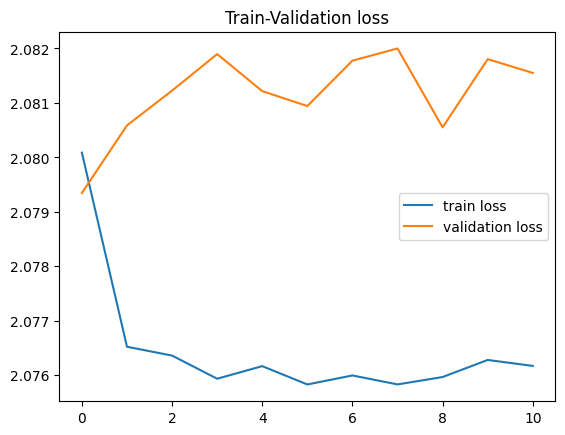

In [15]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5164141414141414, 'as': 0.5202086049543677, 'about': 0.49107142857142855}
Accuracy evaluando en etiquetas female
{'to': 0.07874015748031496, 'as': 0.0862533692722372, 'about': 0.07}
Accuracy evaluando en etiquetas male
{'to': 0.9221411192214112, 'as': 0.9267676767676768, 'about': 0.9296875}


# AdamW

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_adamw_pos'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075275519999062 	 Validation loss: 2.0797467716669633 	 
  1%|          | 574/57400 [00:07<11:39, 81.28it/s]
Epoch 2 	 Training loss: 2.071742973676542 	 Validation loss: 2.073868472697371 	 
  2%|▏         | 1148/57400 [00:15<11:35, 80.83it/s]
Epoch 3 	 Training loss: 2.0674384732694993 	 Validation loss: 2.0740991164061984 	 
  3%|▎         | 1722/57400 [00:22<11:23, 81.44it/s]
Epoch 4 	 Training loss: 2.064152840537892 	 Validation loss: 2.074428849301096 	 
  4%|▍         | 2296/57400 [00:31<11:51, 77.42it/s]
Epoch 5 	 Training loss: 2.0612636164921088 	 Validation loss: 2.0705402139889992 	 
  5%|▌         | 2870/57400 [00:38<11:07, 81.70it/s]
Epoch 6 	 Training loss: 2.060963401395685 	 Validation loss: 2.0700870812949486 	 
  6%|▌         | 3444/57400 [00:46<11:19, 79.42it/s]
Epoch 7 	 Training loss: 2.0580990835764683 	 Validation loss: 2.066698296595428 	 
  7%|▋         | 4018/57400 [00:53<10:49, 82.13it/s]
Epoch 8 	 Training loss: 2.056608777012974

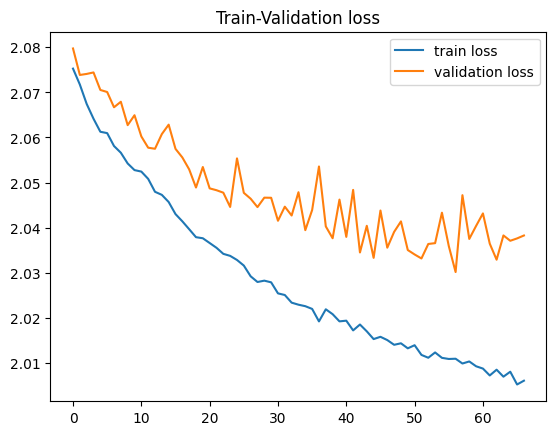

In [18]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [19]:
model =  rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5643939393939394, 'as': 0.560625814863103, 'about': 0.6619897959183674}
Accuracy evaluando en etiquetas female
{'to': 0.4094488188976378, 'as': 0.444743935309973, 'about': 0.525}
Accuracy evaluando en etiquetas male
{'to': 0.708029197080292, 'as': 0.6691919191919192, 'about': 0.8046875}
